## Librerias

In [1]:
from functools import reduce

import cufflinks as cf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc,plot_ks_statistic

sns.set()
cf.go_offline()
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## Datos

In [2]:
ruta='/home/asm/amv/credit_scoring/datos/GiveMeSomeCredit'

In [3]:
df=pd.read_csv(ruta+'/cs-training.csv',index_col=0)
df.reset_index(drop=True,inplace=True)
df.insert(0,'ID',df.index+1)
df.head()

,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
df.shape

(150000, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ID                                    150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

## Variable objetivo

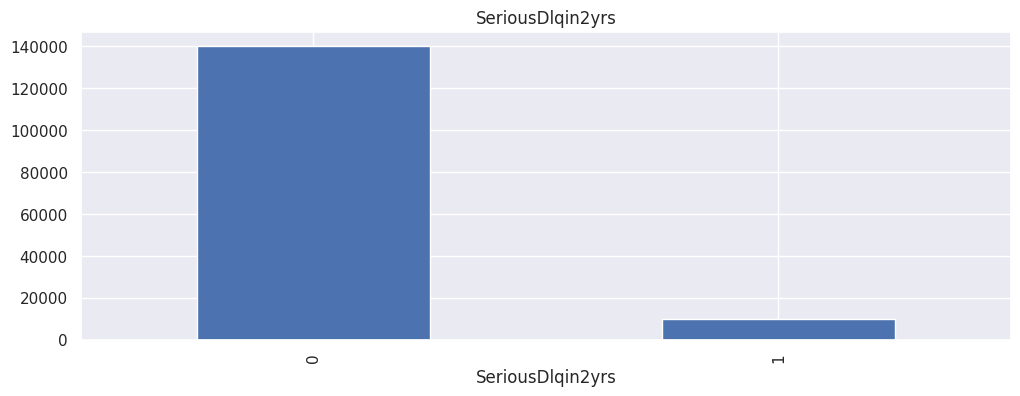

In [6]:
df['SeriousDlqin2yrs'].value_counts(dropna=False).plot(kind='bar',title='SeriousDlqin2yrs',figsize=(12,4))
plt.show()

In [7]:
df['SeriousDlqin2yrs'].value_counts(1)

SeriousDlqin2yrs
0    0.93316
1    0.06684
Name: proportion, dtype: float64

## Variables predictoras

In [8]:
df.nunique().sort_values().iplot(kind='bar',title='Nº de valores únicos por variable',color='blue')

In [9]:
target=['SeriousDlqin2yrs']

um=['ID']

varc=['RevolvingUtilizationOfUnsecuredLines','DebtRatio',
      'MonthlyIncome']

vard=['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate',
      'NumberRealEstateLoansOrLines','NumberOfTime60-89DaysPastDueNotWorse','NumberOfDependents',
      'age','NumberOfOpenCreditLinesAndLoans']

In [10]:
assert len(um)+len(varc)+len(vard)+len(target)==len(df.columns)

### Variables Continuas

In [11]:
df[varc].describe().round(2)

,RevolvingUtilizationOfUnsecuredLines,DebtRatio,MonthlyIncome
count,150000.00,150000.00,120269.00
mean,6.05,353.01,6670.22
std,249.76,2037.82,14384.67
min,0.00,0.00,0.00
25%,0.03,0.18,3400.00
50%,0.15,0.37,5400.00
75%,0.56,0.87,8249.00
max,50708.00,329664.00,3008750.00


In [12]:
df[varc].isna().sum()

RevolvingUtilizationOfUnsecuredLines        0
DebtRatio                                   0
MonthlyIncome                           29731
dtype: int64

In [13]:
"""
sc=StandardScaler()
sc.fit(df[varc])
aux=pd.DataFrame(sc.transform(df[varc]),columns=varc)
aux['Extremo']=(np.abs(aux)>3).max(axis=1).astype(int)
aux[target]=df[target]
aux['Extremo'].value_counts(1),aux['Extremo'].value_counts()
"""

"\nsc=StandardScaler()\nsc.fit(df[varc])\naux=pd.DataFrame(sc.transform(df[varc]),columns=varc)\naux['Extremo']=(np.abs(aux)>3).max(axis=1).astype(int)\naux[target]=df[target]\naux['Extremo'].value_counts(1),aux['Extremo'].value_counts()\n"

In [14]:
"""
aux=aux[aux['Extremo']==0]
aux.drop('Extremo',axis=1,inplace=True)
aux[varc]=sc.inverse_transform(aux[varc])
aux.head()
"""

"\naux=aux[aux['Extremo']==0]\naux.drop('Extremo',axis=1,inplace=True)\naux[varc]=sc.inverse_transform(aux[varc])\naux.head()\n"

In [15]:
"""
from pandas.plotting import scatter_matrix
scatter_matrix(aux[varc],figsize=(8,8))
plt.show()
"""

'\nfrom pandas.plotting import scatter_matrix\nscatter_matrix(aux[varc],figsize=(8,8))\nplt.show()\n'

In [16]:
#aux[varc].corr().round(3)

### Variables discretas

In [17]:
df[vard].astype('category').describe().T.rename(columns={'top':'Moda','freq':'Frecuencia'})

,count,unique,Moda,Frecuencia
NumberOfTime30-59DaysPastDueNotWorse,150000.0,16.0,0.0,126018.0
NumberOfTimes90DaysLate,150000.0,19.0,0.0,141662.0
NumberRealEstateLoansOrLines,150000.0,28.0,0.0,56188.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,13.0,0.0,142396.0
NumberOfDependents,146076.0,13.0,0.0,86902.0
age,150000.0,86.0,49.0,3837.0
NumberOfOpenCreditLinesAndLoans,150000.0,58.0,6.0,13614.0


In [18]:
df[vard].isna().sum()

NumberOfTime30-59DaysPastDueNotWorse       0
NumberOfTimes90DaysLate                    0
NumberRealEstateLoansOrLines               0
NumberOfTime60-89DaysPastDueNotWorse       0
NumberOfDependents                      3924
age                                        0
NumberOfOpenCreditLinesAndLoans            0
dtype: int64

## Partición de los datos

In [19]:
train,test=train_test_split(df,test_size=0.3,random_state=24,stratify=df[target]) 
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)
train.shape,test.shape   

((105000, 12), (45000, 12))

## Análisis de variables continuas

In [20]:
train[varc].describe()

,RevolvingUtilizationOfUnsecuredLines,DebtRatio,MonthlyIncome
count,105000.000000,105000.000000,8.432200e+04
mean,6.091816,349.423909,6.661112e+03
std,270.808329,2168.128094,1.230288e+04
min,0.000000,0.000000,0.000000e+00
25%,0.029709,0.174344,3.400000e+03
50%,0.154002,0.365731,5.400000e+03
75%,0.558301,0.858824,8.253250e+03
max,50708.000000,329664.000000,1.794060e+06


### Clasificación (fine classing) fina de variables continuas
Usando 20 bins con 5% de información en cada uno. Los missing son agrupados en un bin aparte.

In [21]:
#variables continuas discretizadas
varc_disc=[*map(lambda x:f'disc_{x}',varc)]
train[varc_disc]=reduce(lambda x,y:pd.concat([x,y],axis=1),map(lambda x:pd.cut(train[x],np.nanquantile(train[x],np.linspace(0,1,21)),\
                                        include_lowest=True,duplicates='drop').cat.add_categories('missing').fillna('missing'),varc))
train.head()

,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,disc_RevolvingUtilizationOfUnsecuredLines,disc_DebtRatio,disc_MonthlyIncome
0,395,0,0.305246,39,0,0.188282,10154.0,6,0,1,0,2.0,"(0.271, 0.349]","(0.174, 0.214]","(10110.7, 11666.0]"
1,140416,0,0.000000,50,0,0.237976,10000.0,4,0,1,0,1.0,"(-0.001, 0.00286]","(0.214, 0.251]","(9100.0, 10110.7]"
2,140705,0,0.072781,57,0,1757.000000,NaN,13,0,1,0,2.0,"(0.06, 0.0826]","(1252.0, 2425.0]",missing
3,98651,0,0.701374,45,0,0.938085,4166.0,8,0,2,0,2.0,"(0.699, 0.854]","(0.859, 3.269]","(3800.0, 4166.0]"
4,82390,0,0.036075,60,0,0.010930,3750.0,3,0,0,0,0.0,"(0.0297, 0.0432]","(0.00434, 0.0307]","(3400.0, 3800.0]"


### Classificación gruesa de variables continuas

In [22]:
def WOE(df:pd.DataFrame,var:str,target:str='SeriousDlqin2yrs',sort:str='index')->pd.DataFrame:
    """Realiza la transformación WOE sobre una variable

    Args:
        df (pd.DataFrame): Conjunto de datos
        var (str): Variable a transformar
        target (str, optional): Variable objetivo. Defaults to SeriousDlqin2yrs.
        sort (str, optional): Ordenar valores por index o WoE. Defaults to 'index'.

    Returns:
        pd.DataFrame: DataFrame con la transformación WOE
    """
    aux=pd.crosstab(df[var],df[target])
    aux/=aux.sum()
    if isinstance(aux.columns[0],str):
        aux.rename(columns={'0':'Good','1':'Bad'},inplace=True)
    elif isinstance(aux.columns[0],np.int64):
        aux.rename(columns={0:'Good',1:'Bad'},inplace=True)
    aux['WoE']=np.log(aux['Good']/aux['Bad'])
    aux['IV']=(aux['Good']-aux['Bad'])*aux['WoE']
    if sort=='index':
        return aux.sort_index()
    elif sort=='WoE':
        return aux.sort_values('WoE')
    else:
        raise ValueError('sort debe ser index o WoE')
    

def plot_WOE(df:pd.DataFrame,var:str,target:str='SeriousDlqin2yrs',sort:str='index',ax=None):
    """Grafica la transformación WOE de una variable

    Args:
        df (pd.DataFrame): Conjunto de datos
        var (str): Variable a transformar
        target (str, optional): Variable objetivo. Defaults to SeriousDlqin2yrs.
        sort (str, optional): Ordenar valores por index o WoE. Defaults to 'index'.

    Returns:
        pd.DataFrame: DataFrame con la transformación WOE    
    """
    aux=WOE(df,var,target,sort)
    aux['WoE'].plot(kind='line',linestyle='-.',ax=ax).axes.get_xaxis().set_visible(False)
    aux['WoE'].plot(kind='bar',alpha=0.5,ax=ax).axes.get_xaxis().set_visible(True)
    

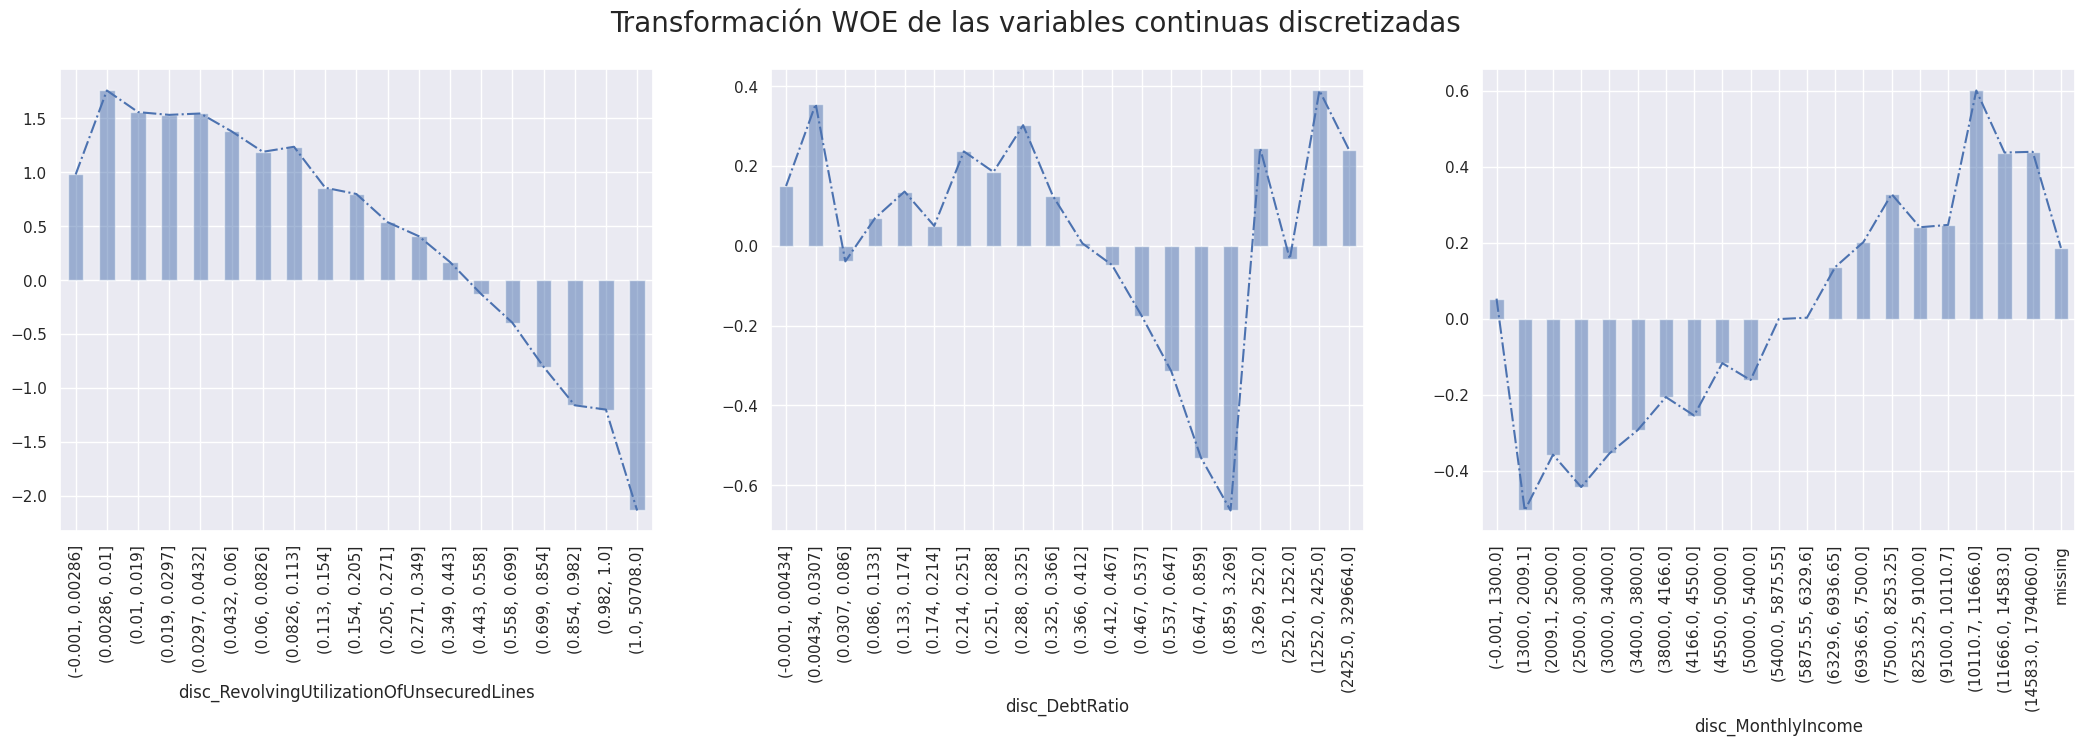

In [23]:
fig,ax=plt.subplots(1,3,figsize=(26,6))
for i,v in enumerate(varc_disc):
    plot_WOE(train,v,ax=ax[i])
fig.suptitle('Transformación WOE de las variables continuas discretizadas',fontsize=20)
plt.show()

In [24]:
train['disc_RevolvingUtilizationOfUnsecuredLines']=np.where(train['RevolvingUtilizationOfUnsecuredLines']<=0.00286,'[0,0.00286]',\
                                                            np.where(train['RevolvingUtilizationOfUnsecuredLines']<=0.006,'(0.00286,0.006]',\
                                                                     np.where(train['RevolvingUtilizationOfUnsecuredLines']<=0.113,'(0.006,0.113]',\
                                                                              np.where(train['RevolvingUtilizationOfUnsecuredLines']<=0.205,'(0.113,0.205]',\
                                                                                       np.where(train['RevolvingUtilizationOfUnsecuredLines']<=0.558,'(0.205,0.558]',\
                                                                                                np.where(train['RevolvingUtilizationOfUnsecuredLines']<=0.854,'(0.558,0.854]',\
                                                                                                         np.where(train['RevolvingUtilizationOfUnsecuredLines']<=1,'(0.854,1]',\
                                                                                                                  '>1')))))))

train['disc_DebtRatio']=np.where(train['DebtRatio']<=0.412,'[0,0.412]',\
                                 np.where(train['DebtRatio']<=0.647,'(0.412,0.647]',\
                                          np.where(train['DebtRatio']<=3.269,'(0.647,3.269]','>3.269')))

train['disc_MonthlyIncome']=np.where(train['MonthlyIncome']<=3800.0,'[0,3800.0]',\
                                     np.where(train['MonthlyIncome']<=5400.0,'(3800.0,5400.0]',\
                                                np.where(train['MonthlyIncome']<=6329.6,'(5400.0,6329.6]',\
                                                            np.where(train['MonthlyIncome']<=7500.0,'(6329.6,7500.0]',\
                                                                        np.where(train['MonthlyIncome']<=10110.7,'(7500.0,10110.7]',\
                                                                                    np.where(train['MonthlyIncome']<=11666.0,'(10110.7,11666.0]',\
                                                                                                np.where(train['MonthlyIncome']>10110.7,'>10110.7','missing')))))))

## Análisis de variables discretas

In [25]:
train[vard].describe()

,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age,NumberOfOpenCreditLinesAndLoans
count,105000.000000,105000.000000,105000.000000,105000.000000,102278.000000,105000.000000,105000.000000
mean,0.413914,0.258086,1.016790,0.232667,0.758619,52.303619,8.450181
std,4.101780,4.076976,1.130304,4.062789,1.116198,14.779814,5.152970
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,41.000000,5.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,52.000000,8.000000
75%,0.000000,0.000000,2.000000,0.000000,1.000000,63.000000,11.000000
max,98.000000,98.000000,54.000000,98.000000,20.000000,109.000000,58.000000


In [26]:
vard_disc=[*map(lambda x:f'disc_{x}',vard)]
train[vard_disc]=reduce(lambda x,y:pd.concat([x,y],axis=1),map(lambda x:train[x].astype('category').cat.add_categories('missing').fillna('missing'),vard))
train.head()

,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,disc_RevolvingUtilizationOfUnsecuredLines,disc_DebtRatio,disc_MonthlyIncome,disc_NumberOfTime30-59DaysPastDueNotWorse,disc_NumberOfTimes90DaysLate,disc_NumberRealEstateLoansOrLines,disc_NumberOfTime60-89DaysPastDueNotWorse,disc_NumberOfDependents,disc_age,disc_NumberOfOpenCreditLinesAndLoans
0,395,0,0.305246,39,0,0.188282,10154.0,6,0,1,0,2.0,"(0.205,0.558]","[0,0.412]","(10110.7,11666.0]",0,0,1,0,2.0,39,6
1,140416,0,0.000000,50,0,0.237976,10000.0,4,0,1,0,1.0,"[0,0.00286]","[0,0.412]","(7500.0,10110.7]",0,0,1,0,1.0,50,4
2,140705,0,0.072781,57,0,1757.000000,NaN,13,0,1,0,2.0,"(0.006,0.113]",>3.269,missing,0,0,1,0,2.0,57,13
3,98651,0,0.701374,45,0,0.938085,4166.0,8,0,2,0,2.0,"(0.558,0.854]","(0.647,3.269]","(3800.0,5400.0]",0,0,2,0,2.0,45,8
4,82390,0,0.036075,60,0,0.010930,3750.0,3,0,0,0,0.0,"(0.006,0.113]","[0,0.412]","[0,3800.0]",0,0,0,0,0.0,60,3


### Classificación gruesa de variables discretas

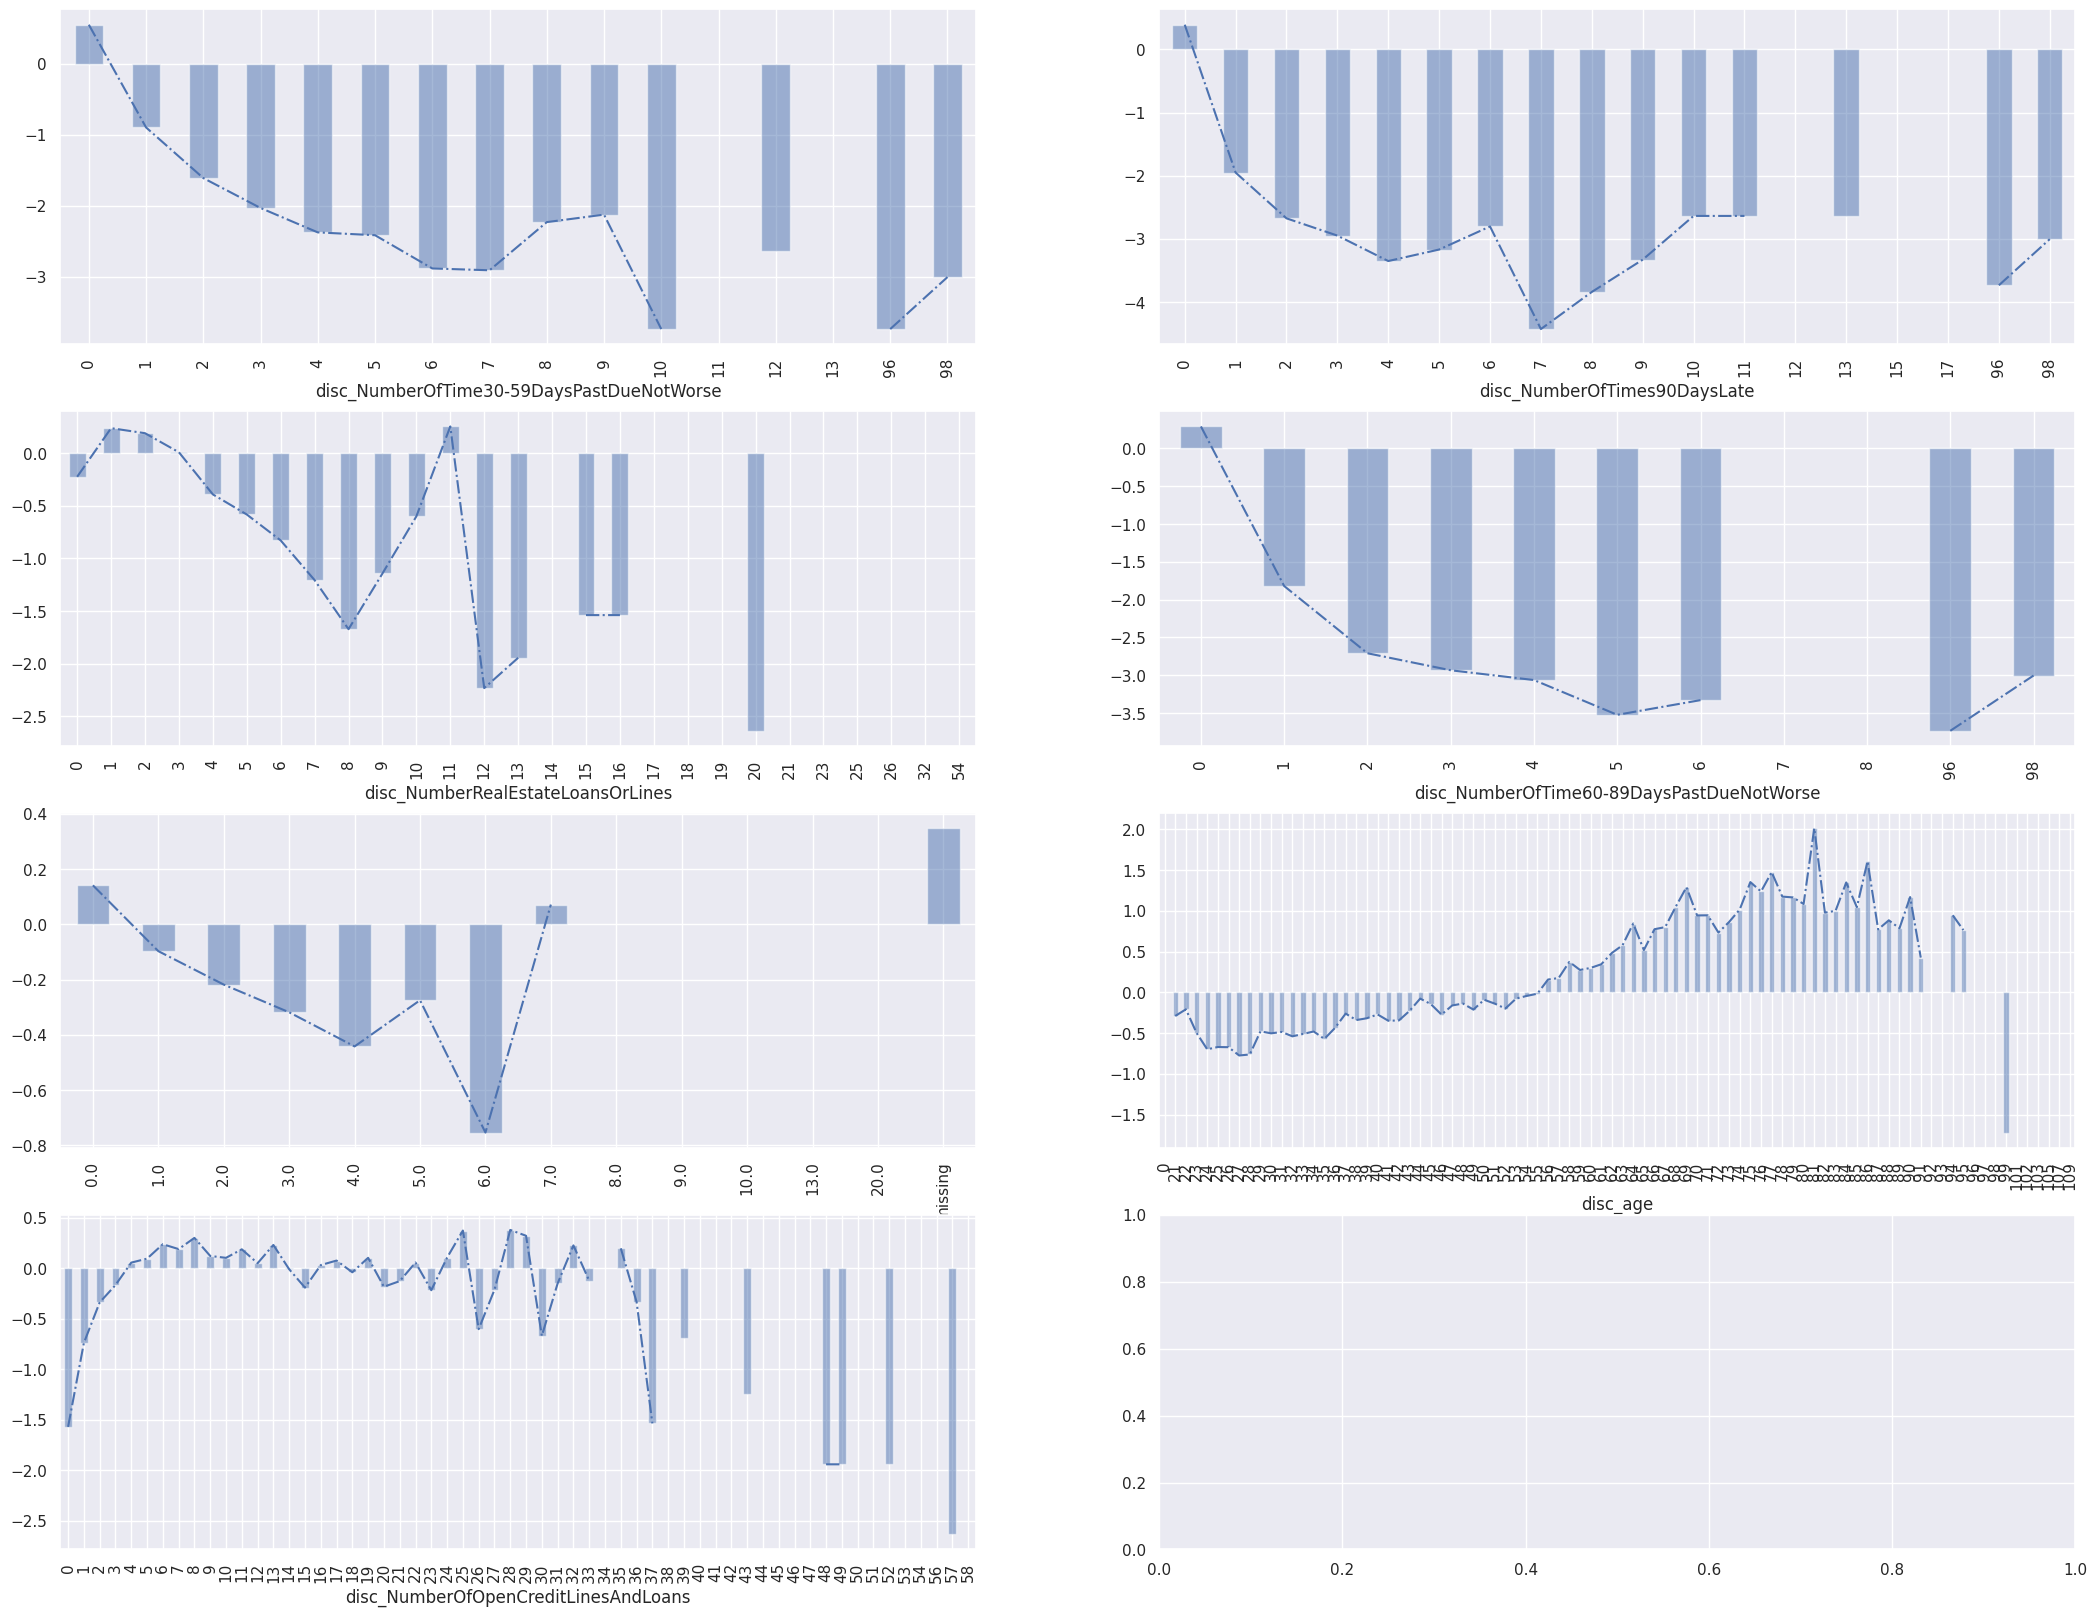

In [27]:
fig,ax=plt.subplots(4,2,figsize=(26,20))
for i,v in enumerate(vard_disc):
    plot_WOE(train,v,ax=ax[i//2,i%2])

In [28]:
train['disc_NumberOfTime30-59DaysPastDueNotWorse']=np.where(train['NumberOfTime30-59DaysPastDueNotWorse']<=0,'0',\
                                                            np.where(train['NumberOfTime30-59DaysPastDueNotWorse']<=1,'1',\
                                                                        np.where(train['NumberOfTime30-59DaysPastDueNotWorse']<=5,'[2,5]',\
                                                                                    np.where(train['NumberOfTime30-59DaysPastDueNotWorse']>5,'>5','missing'))))

train['disc_NumberOfTimes90DaysLate']=np.where(train['NumberOfTimes90DaysLate']<=0,'0',\
                                                            np.where(train['NumberOfTimes90DaysLate']<=1,'1',\
                                                                        np.where(train['NumberOfTimes90DaysLate']>1,'>1','missing')))

train['disc_NumberRealEstateLoansOrLines']=np.where(train['NumberRealEstateLoansOrLines']<=0,'0',\
                                                            np.where(train['NumberRealEstateLoansOrLines']<=3,'[1,3]',\
                                                                        np.where(train['NumberRealEstateLoansOrLines']>3,'>3','missing')))

train['disc_NumberOfTime60-89DaysPastDueNotWorse']=np.where(train['NumberOfTime60-89DaysPastDueNotWorse']<=0,'0',\
                                                            np.where(train['NumberOfTime60-89DaysPastDueNotWorse']<=1,'1',\
                                                                        np.where(train['NumberOfTime60-89DaysPastDueNotWorse']>1,'>1','missing')))

train['disc_NumberOfDependents']=np.where(train['NumberOfDependents']<=0,'0',\
                                                            np.where(train['NumberOfDependents']<=1,'1',\
                                                                        np.where(train['NumberOfDependents']<=2,'2',\
                                                                                    np.where(train['NumberOfDependents']>2,'>2','missing'))))

train['disc_age']=np.where(train['age']<=28,'[0,28]',\
                           np.where(train['age']<=36,'(28,36]',\
                                    np.where(train['age']<=55,'(36,55]',\
                                                np.where(train['age']<=70,'(55,70]',\
                                                            np.where(train['age']>70,'>70','missing')))))

train['disc_NumberOfOpenCreditLinesAndLoans']=np.where(train['NumberOfOpenCreditLinesAndLoans']<=3,'[0,3]',\
                                                       np.where(train['NumberOfOpenCreditLinesAndLoans']<=13,'(3,13]',\
                                                                np.where(train['NumberOfOpenCreditLinesAndLoans']<=17,'(13,17]',\
                                                                            np.where(train['NumberOfOpenCreditLinesAndLoans']<=23,'(17,23]',\
                                                                                        np.where(train['NumberOfOpenCreditLinesAndLoans']<=32,'(23,32]',\
                                                                                                    np.where(train['NumberOfOpenCreditLinesAndLoans']>32,'>32','missing'))))))
                                                                                                 

## Selección de variables

In [29]:
iv=pd.Series({v:WOE(train,v)['IV'].sum() for v in varc_disc+vard_disc}).sort_values(ascending=False)
iv.iplot(kind='bar',title='IV de las variables discretizadas',xTitle='Variables',yTitle='IV',fontsize=15,color='blue')

In [30]:
iv[iv>.1].round(4).to_clipboard()

In [31]:
best=iv[iv>.1].index.tolist()
best

['disc_RevolvingUtilizationOfUnsecuredLines',
 'disc_NumberOfTimes90DaysLate',
 'disc_NumberOfTime30-59DaysPastDueNotWorse',
 'disc_NumberOfTime60-89DaysPastDueNotWorse',
 'disc_age']

## Transformación WoE

In [32]:
mapa_woe=dict(zip(best,map(lambda x:WOE(train,x)['WoE'].to_dict(),best)))

In [33]:
vars_woe=[*map(lambda x:x.replace('disc','woe'),best)]
train[vars_woe]=reduce(lambda x,y:pd.concat([x,y],axis=1),map(lambda x:train[x].map(mapa_woe[x]),best))
train.head()

,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,disc_RevolvingUtilizationOfUnsecuredLines,disc_DebtRatio,disc_MonthlyIncome,disc_NumberOfTime30-59DaysPastDueNotWorse,disc_NumberOfTimes90DaysLate,disc_NumberRealEstateLoansOrLines,disc_NumberOfTime60-89DaysPastDueNotWorse,disc_NumberOfDependents,disc_age,disc_NumberOfOpenCreditLinesAndLoans,woe_RevolvingUtilizationOfUnsecuredLines,woe_NumberOfTimes90DaysLate,woe_NumberOfTime30-59DaysPastDueNotWorse,woe_NumberOfTime60-89DaysPastDueNotWorse,woe_age
0,395,0,0.305246,39,0,0.188282,10154.0,6,0,1,0,2.0,"(0.205,0.558]","[0,0.412]","(10110.7,11666.0]",0,0,"[1,3]",0,2,"(36,55]","(3,13]",0.216695,0.392421,0.54606,0.290427,-0.190908
1,140416,0,0.000000,50,0,0.237976,10000.0,4,0,1,0,1.0,"[0,0.00286]","[0,0.412]","(7500.0,10110.7]",0,0,"[1,3]",0,1,"(36,55]","(3,13]",0.980003,0.392421,0.54606,0.290427,-0.190908
2,140705,0,0.072781,57,0,1757.000000,NaN,13,0,1,0,2.0,"(0.006,0.113]",>3.269,missing,0,0,"[1,3]",0,2,"(55,70]","(3,13]",1.423930,0.392421,0.54606,0.290427,0.498178
3,98651,0,0.701374,45,0,0.938085,4166.0,8,0,2,0,2.0,"(0.558,0.854]","(0.647,3.269]","(3800.0,5400.0]",0,0,"[1,3]",0,2,"(36,55]","(3,13]",-0.614046,0.392421,0.54606,0.290427,-0.190908
4,82390,0,0.036075,60,0,0.010930,3750.0,3,0,0,0,0.0,"(0.006,0.113]","[0,0.412]","[0,3800.0]",0,0,0,0,0,"(55,70]","[0,3]",1.423930,0.392421,0.54606,0.290427,0.498178


## Entrenamiento del modelo

In [34]:
modelo=LogisticRegression()
param_grid={'C':np.linspace(0,1,21),'penalty':['l1','l2'],'class_weight':[None,'balanced']}
gs=GridSearchCV(modelo,param_grid,cv=5,scoring='roc_auc',n_jobs=-1)
gs.fit(train[vars_woe],train['SeriousDlqin2yrs'])

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [35]:
modelo=gs.best_estimator_
modelo

LogisticRegression(C=0.7000000000000001, class_weight='balanced')

In [36]:
roc_auc_score(train['SeriousDlqin2yrs'],modelo.predict_proba(train[vars_woe])[:,1])

0.8504190795677112

<Axes: title={'center': 'Curva ROC para el modelo de regresión logística'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

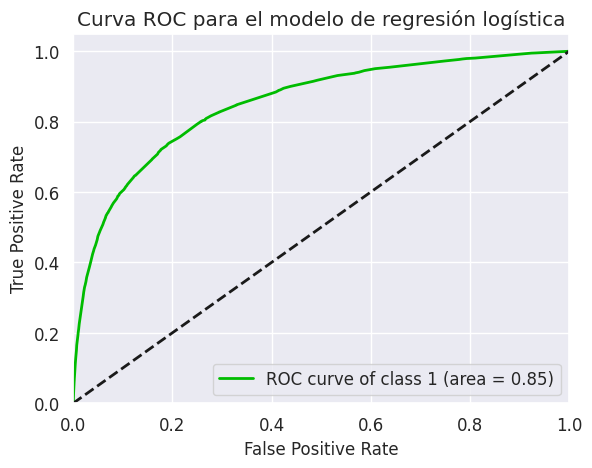

In [37]:
plot_roc(train['SeriousDlqin2yrs'],modelo.predict_proba(train[vars_woe]),plot_micro=False,plot_macro=False,classes_to_plot=[1],title='Curva ROC para el modelo de regresión logística')

<Axes: title={'center': 'Curva KS para el modelo de regresión logística'}, xlabel='Threshold', ylabel='Percentage below threshold'>

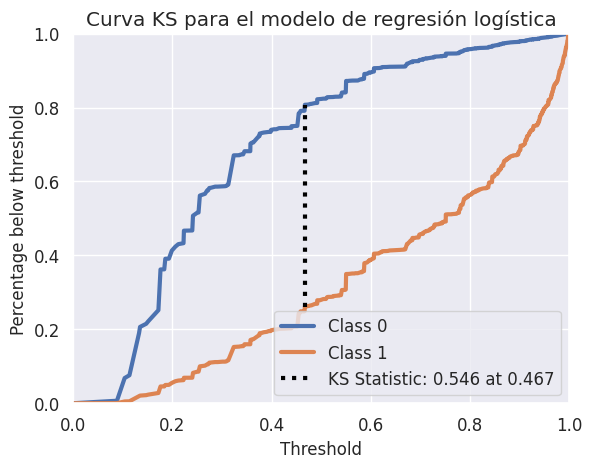

In [38]:
plot_ks_statistic(train['SeriousDlqin2yrs'],modelo.predict_proba(train[vars_woe]),title='Curva KS para el modelo de regresión logística')

## Evaluación del modelo

In [39]:
test.head()

,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,103371,0,0.016135,61,0,0.020947,4200.0,19,0,0,0,1.0
1,48446,1,0.718657,55,0,0.705937,12833.0,9,0,2,0,0.0
2,74172,0,0.168523,38,0,0.330087,4825.0,11,0,2,0,1.0
3,112404,0,0.233777,48,1,0.433428,6000.0,9,0,2,0,2.0
4,127704,0,0.999911,49,1,0.146971,5000.0,2,2,0,1,0.0


### clasificacion gruesa de variables continuas

In [40]:
test['disc_RevolvingUtilizationOfUnsecuredLines']=np.where(test['RevolvingUtilizationOfUnsecuredLines']<=0.00286,'[0,0.00286]',\
                                                            np.where(test['RevolvingUtilizationOfUnsecuredLines']<=0.006,'(0.00286,0.006]',\
                                                                    np.where(test['RevolvingUtilizationOfUnsecuredLines']<=0.113,'(0.006,0.113]',\
                                                                        np.where(test['RevolvingUtilizationOfUnsecuredLines']<=0.205,'(0.113,0.205]',\
                                                                            np.where(test['RevolvingUtilizationOfUnsecuredLines']<=0.558,'(0.205,0.558]',\
                                                                                np.where(test['RevolvingUtilizationOfUnsecuredLines']<=0.854,'(0.558,0.854]',\
                                                                                    np.where(test['RevolvingUtilizationOfUnsecuredLines']<=1,'(0.854,1]','>1')))))))

test['disc_DebtRatio']=np.where(test['DebtRatio']<=0.412,'[0,0.412]',\
                                np.where(test['DebtRatio']<=0.647,'(0.412,0.647]',\
                                        np.where(test['DebtRatio']<=3.269,'(0.647,3.269]','>3.269')))

test['disc_MonthlyIncome']=np.where(test['MonthlyIncome']<=3800.0,'[0,3800.0]',\
                            np.where(test['MonthlyIncome']<=5400.0,'(3800.0,5400.0]',\
                                np.where(test['MonthlyIncome']<=6329.6,'(5400.0,6329.6]',\
                                    np.where(test['MonthlyIncome']<=7500.0,'(6329.6,7500.0]',\
                                        np.where(test['MonthlyIncome']<=10110.7,'(7500.0,10110.7]',\
                                            np.where(test['MonthlyIncome']<=11666.0,'(10110.7,11666.0]',\
                                                np.where(test['MonthlyIncome']>10110.7,'>10110.7','missing')))))))

### clasificacion gruesa de variables discretas

In [41]:
test['disc_NumberOfTime30-59DaysPastDueNotWorse'] = np.where(test['NumberOfTime30-59DaysPastDueNotWorse'] <= 0, '0', \
                                                            np.where(test['NumberOfTime30-59DaysPastDueNotWorse'] <= 1, '1', \
                                                                        np.where(test['NumberOfTime30-59DaysPastDueNotWorse'] <= 5, '[2,5]', \
                                                                                    np.where(test['NumberOfTime30-59DaysPastDueNotWorse'] > 5, '>5', 'missing'))))

test['disc_NumberOfTimes90DaysLate'] = np.where(test['NumberOfTimes90DaysLate'] <= 0, '0', \
                                                np.where(test['NumberOfTimes90DaysLate'] <= 1, '1', \
                                                            np.where(test['NumberOfTimes90DaysLate'] > 1, '>1', 'missing')))

test['disc_NumberRealEstateLoansOrLines'] = np.where(test['NumberRealEstateLoansOrLines'] <= 0, '0', \
                                                        np.where(test['NumberRealEstateLoansOrLines'] <= 3, '[1,3]', \
                                                                    np.where(test['NumberRealEstateLoansOrLines'] > 3, '>3', 'missing')))

test['disc_NumberOfTime60-89DaysPastDueNotWorse'] = np.where(test['NumberOfTime60-89DaysPastDueNotWorse'] <= 0, '0', \
                                                                np.where(test['NumberOfTime60-89DaysPastDueNotWorse'] <= 1, '1', \
                                                                            np.where(test['NumberOfTime60-89DaysPastDueNotWorse'] > 1, '>1', 'missing')))

test['disc_NumberOfDependents'] = np.where(test['NumberOfDependents'] <= 0, '0', \
                                            np.where(test['NumberOfDependents'] <= 1, '1', \
                                                        np.where(test['NumberOfDependents'] <= 2, '2', \
                                                                    np.where(test['NumberOfDependents'] > 2, '>2', 'missing'))))

test['disc_age'] = np.where(test['age'] <= 28, '[0,28]', \
                            np.where(test['age'] <= 36, '(28,36]', \
                                    np.where(test['age'] <= 55, '(36,55]', \
                                                np.where(test['age'] <= 70, '(55,70]', \
                                                            np.where(test['age'] > 70, '>70', 'missing')))))

test['disc_NumberOfOpenCreditLinesAndLoans'] = np.where(test['NumberOfOpenCreditLinesAndLoans'] <= 3, '[0,3]', \
                                                        np.where(test['NumberOfOpenCreditLinesAndLoans'] <= 13, '(3,13]', \
                                                                    np.where(test['NumberOfOpenCreditLinesAndLoans'] <= 17, '(13,17]', \
                                                                                np.where(test['NumberOfOpenCreditLinesAndLoans'] <= 23, '(17,23]', \
                                                                                            np.where(test['NumberOfOpenCreditLinesAndLoans'] <= 32, '(23,32]', \
                                                                                                        np.where(test['NumberOfOpenCreditLinesAndLoans'] > 32, '>32', 'missing'))))))



### Transformación WoE

In [42]:
test[vars_woe]=reduce(lambda x,y:pd.concat([x,y],axis=1),map(lambda x:test[x].map(mapa_woe[x]),best))
test.head()

,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,disc_RevolvingUtilizationOfUnsecuredLines,disc_DebtRatio,disc_MonthlyIncome,disc_NumberOfTime30-59DaysPastDueNotWorse,disc_NumberOfTimes90DaysLate,disc_NumberRealEstateLoansOrLines,disc_NumberOfTime60-89DaysPastDueNotWorse,disc_NumberOfDependents,disc_age,disc_NumberOfOpenCreditLinesAndLoans,woe_RevolvingUtilizationOfUnsecuredLines,woe_NumberOfTimes90DaysLate,woe_NumberOfTime30-59DaysPastDueNotWorse,woe_NumberOfTime60-89DaysPastDueNotWorse,woe_age
0,103371,0,0.016135,61,0,0.020947,4200.0,19,0,0,0,1.0,"(0.006,0.113]","[0,0.412]","(3800.0,5400.0]",0,0,0,0,1,"(55,70]","(17,23]",1.423930,0.392421,0.546060,0.290427,0.498178
1,48446,1,0.718657,55,0,0.705937,12833.0,9,0,2,0,0.0,"(0.558,0.854]","(0.647,3.269]",>10110.7,0,0,"[1,3]",0,0,"(36,55]","(3,13]",-0.614046,0.392421,0.546060,0.290427,-0.190908
2,74172,0,0.168523,38,0,0.330087,4825.0,11,0,2,0,1.0,"(0.113,0.205]","[0,0.412]","(3800.0,5400.0]",0,0,"[1,3]",0,1,"(36,55]","(3,13]",0.826782,0.392421,0.546060,0.290427,-0.190908
3,112404,0,0.233777,48,1,0.433428,6000.0,9,0,2,0,2.0,"(0.205,0.558]","(0.412,0.647]","(5400.0,6329.6]",1,0,"[1,3]",0,2,"(36,55]","(3,13]",0.216695,0.392421,-0.898907,0.290427,-0.190908
4,127704,0,0.999911,49,1,0.146971,5000.0,2,2,0,1,0.0,"(0.854,1]","[0,0.412]","(3800.0,5400.0]",1,>1,0,1,0,"(36,55]","[0,3]",-1.188028,-2.878141,-0.898907,-1.820338,-0.190908


### Medidas de desempeño

In [43]:
roc_auc_score(test['SeriousDlqin2yrs'],modelo.predict_proba(test[vars_woe])[:,1])

0.8589773812033092

<Axes: title={'center': 'Curva ROC para el modelo de regresión logística'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

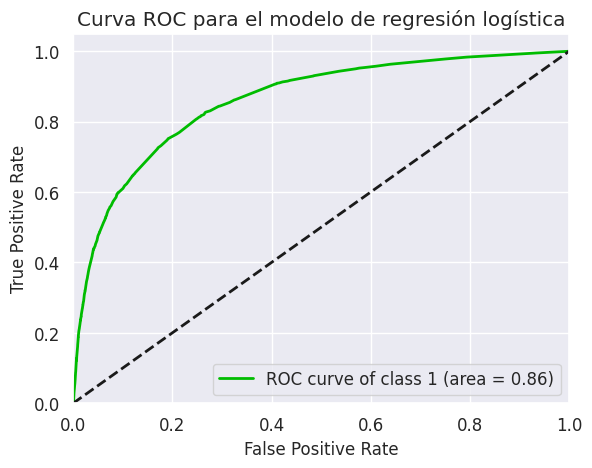

In [44]:
plot_roc(test['SeriousDlqin2yrs'],modelo.predict_proba(test[vars_woe]),plot_micro=False,plot_macro=False,classes_to_plot=[1],title='Curva ROC para el modelo de regresión logística')

<Axes: title={'center': 'Curva KS para el modelo de regresión logística'}, xlabel='Threshold', ylabel='Percentage below threshold'>

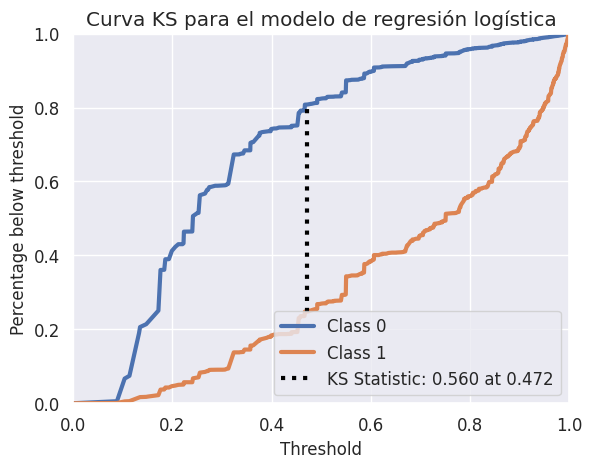

In [45]:
plot_ks_statistic(test['SeriousDlqin2yrs'],modelo.predict_proba(test[vars_woe]),title='Curva KS para el modelo de regresión logística')

## Predicción

In [46]:
pred=pd.read_csv(ruta+'/cs-test.csv')
pred['Id']=pred.index+1
pred.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Id
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0,1
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0,2
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0,3
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0,4
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0,5


### clasificacion gruesa de variables continuas

In [47]:
pred['disc_RevolvingUtilizationOfUnsecuredLines'] = np.where(pred['RevolvingUtilizationOfUnsecuredLines'] <= 0.00286, '[0,0.00286]', \
                                                            np.where(pred['RevolvingUtilizationOfUnsecuredLines'] <= 0.006, '(0.00286,0.006]', \
                                                                    np.where(pred['RevolvingUtilizationOfUnsecuredLines'] <= 0.113, '(0.006,0.113]', \
                                                                        np.where(pred['RevolvingUtilizationOfUnsecuredLines'] <= 0.205, '(0.113,0.205]', \
                                                                            np.where(pred['RevolvingUtilizationOfUnsecuredLines'] <= 0.558, '(0.205,0.558]', \
                                                                                np.where(pred['RevolvingUtilizationOfUnsecuredLines'] <= 0.854, '(0.558,0.854]', \
                                                                                    np.where(pred['RevolvingUtilizationOfUnsecuredLines'] <= 1, '(0.854,1]', '>1')))))))

pred['disc_DebtRatio'] = np.where(pred['DebtRatio'] <= 0.412, '[0,0.412]', \
                                np.where(pred['DebtRatio'] <= 0.647, '(0.412,0.647]', \
                                        np.where(pred['DebtRatio'] <= 3.269, '(0.647,3.269]', '>3.269')))

pred['disc_MonthlyIncome'] = np.where(pred['MonthlyIncome'] <= 3800.0, '[0,3800.0]', \
                            np.where(pred['MonthlyIncome'] <= 5400.0, '(3800.0,5400.0]', \
                                np.where(pred['MonthlyIncome'] <= 6329.6, '(5400.0,6329.6]', \
                                    np.where(pred['MonthlyIncome'] <= 7500.0, '(6329.6,7500.0]', \
                                        np.where(pred['MonthlyIncome'] <= 10110.7, '(7500.0,10110.7]', \
                                            np.where(pred['MonthlyIncome'] <= 11666.0, '(10110.7,11666.0]', \
                                                np.where(pred['MonthlyIncome'] > 10110.7, '>10110.7', 'missing')))))))



### clasificacion gruesa de variables discretas

In [48]:
pred['disc_NumberOfTime30-59DaysPastDueNotWorse'] = np.where(pred['NumberOfTime30-59DaysPastDueNotWorse'] <= 0, '0', \
                                                            np.where(pred['NumberOfTime30-59DaysPastDueNotWorse'] <= 1, '1', \
                                                                        np.where(pred['NumberOfTime30-59DaysPastDueNotWorse'] <= 5, '[2,5]', \
                                                                                    np.where(pred['NumberOfTime30-59DaysPastDueNotWorse'] > 5, '>5', 'missing'))))

pred['disc_NumberOfTimes90DaysLate'] = np.where(pred['NumberOfTimes90DaysLate'] <= 0, '0', \
                                                np.where(pred['NumberOfTimes90DaysLate'] <= 1, '1', \
                                                            np.where(pred['NumberOfTimes90DaysLate'] > 1, '>1', 'missing')))

pred['disc_NumberRealEstateLoansOrLines'] = np.where(pred['NumberRealEstateLoansOrLines'] <= 0, '0', \
                                                        np.where(pred['NumberRealEstateLoansOrLines'] <= 3, '[1,3]', \
                                                                    np.where(pred['NumberRealEstateLoansOrLines'] > 3, '>3', 'missing')))

pred['disc_NumberOfTime60-89DaysPastDueNotWorse'] = np.where(pred['NumberOfTime60-89DaysPastDueNotWorse'] <= 0, '0', \
                                                                np.where(pred['NumberOfTime60-89DaysPastDueNotWorse'] <= 1, '1', \
                                                                            np.where(pred['NumberOfTime60-89DaysPastDueNotWorse'] > 1, '>1', 'missing')))

pred['disc_NumberOfDependents'] = np.where(pred['NumberOfDependents'] <= 0, '0', \
                                            np.where(pred['NumberOfDependents'] <= 1, '1', \
                                                        np.where(pred['NumberOfDependents'] <= 2, '2', \
                                                                    np.where(pred['NumberOfDependents'] > 2, '>2', 'missing'))))

pred['disc_age'] = np.where(pred['age'] <= 28, '[0,28]', \
                            np.where(pred['age'] <= 36, '(28,36]', \
                                    np.where(pred['age'] <= 55, '(36,55]', \
                                                np.where(pred['age'] <= 70, '(55,70]', \
                                                            np.where(pred['age'] > 70, '>70', 'missing')))))

pred['disc_NumberOfOpenCreditLinesAndLoans'] = np.where(pred['NumberOfOpenCreditLinesAndLoans'] <= 3, '[0,3]', \
                                                        np.where(pred['NumberOfOpenCreditLinesAndLoans'] <= 13, '(3,13]', \
                                                                    np.where(pred['NumberOfOpenCreditLinesAndLoans'] <= 17, '(13,17]', \
                                                                                np.where(pred['NumberOfOpenCreditLinesAndLoans'] <= 23, '(17,23]', \
                                                                                            np.where(pred['NumberOfOpenCreditLinesAndLoans'] <= 32, '(23,32]', \
                                                                                                        np.where(pred['NumberOfOpenCreditLinesAndLoans'] > 32, '>32', 'missing'))))))



### Transformación WoE

In [49]:
pred[vars_woe]=reduce(lambda x,y:pd.concat([x,y],axis=1),map(lambda x:pred[x].map(mapa_woe[x]),best))
pred.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Id,disc_RevolvingUtilizationOfUnsecuredLines,disc_DebtRatio,disc_MonthlyIncome,disc_NumberOfTime30-59DaysPastDueNotWorse,disc_NumberOfTimes90DaysLate,disc_NumberRealEstateLoansOrLines,disc_NumberOfTime60-89DaysPastDueNotWorse,disc_NumberOfDependents,disc_age,disc_NumberOfOpenCreditLinesAndLoans,woe_RevolvingUtilizationOfUnsecuredLines,woe_NumberOfTimes90DaysLate,woe_NumberOfTime30-59DaysPastDueNotWorse,woe_NumberOfTime60-89DaysPastDueNotWorse,woe_age
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0,1,"(0.854,1]","[0,0.412]","(5400.0,6329.6]",0,0,0,0,0,"(36,55]","(3,13]",-1.188028,0.392421,0.546060,0.290427,-0.190908
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0,2,"(0.205,0.558]","(0.412,0.647]","(7500.0,10110.7]",0,0,>3,0,2,"(55,70]","(13,17]",0.216695,0.392421,0.546060,0.290427,0.498178
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0,3,"(0.006,0.113]","(0.647,3.269]","(3800.0,5400.0]",0,0,"[1,3]",0,2,"(55,70]","(3,13]",1.423930,0.392421,0.546060,0.290427,0.498178
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0,4,"(0.205,0.558]","(0.647,3.269]","[0,3800.0]",1,0,"[1,3]",0,0,"(36,55]","(3,13]",0.216695,0.392421,-0.898907,0.290427,-0.190908
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0,5,"(0.854,1]","[0,0.412]","(3800.0,5400.0]",0,0,0,0,1,"[0,28]","(3,13]",-1.188028,0.392421,0.546060,0.290427,-0.667246


### predicción

In [50]:
pred['Probability']=modelo.predict_proba(pred[vars_woe])[:,1]
pred[['Id','Probability']].to_csv(ruta+'/pred.csv',index=False)
pred.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Id,disc_RevolvingUtilizationOfUnsecuredLines,disc_DebtRatio,disc_MonthlyIncome,disc_NumberOfTime30-59DaysPastDueNotWorse,disc_NumberOfTimes90DaysLate,disc_NumberRealEstateLoansOrLines,disc_NumberOfTime60-89DaysPastDueNotWorse,disc_NumberOfDependents,disc_age,disc_NumberOfOpenCreditLinesAndLoans,woe_RevolvingUtilizationOfUnsecuredLines,woe_NumberOfTimes90DaysLate,woe_NumberOfTime30-59DaysPastDueNotWorse,woe_NumberOfTime60-89DaysPastDueNotWorse,woe_age,Probability
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0,1,"(0.854,1]","[0,0.412]","(5400.0,6329.6]",0,0,0,0,0,"(36,55]","(3,13]",-1.188028,0.392421,0.546060,0.290427,-0.190908,0.550384
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0,2,"(0.205,0.558]","(0.412,0.647]","(7500.0,10110.7]",0,0,>3,0,2,"(55,70]","(13,17]",0.216695,0.392421,0.546060,0.290427,0.498178,0.255504
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0,3,"(0.006,0.113]","(0.647,3.269]","(3800.0,5400.0]",0,0,"[1,3]",0,2,"(55,70]","(3,13]",1.423930,0.392421,0.546060,0.290427,0.498178,0.132863
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0,4,"(0.205,0.558]","(0.647,3.269]","[0,3800.0]",1,0,"[1,3]",0,0,"(36,55]","(3,13]",0.216695,0.392421,-0.898907,0.290427,-0.190908,0.541825
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0,5,"(0.854,1]","[0,0.412]","(3800.0,5400.0]",0,0,0,0,1,"[0,28]","(3,13]",-1.188028,0.392421,0.546060,0.290427,-0.667246,0.606508


### parametros del modelo

In [51]:
modelo.intercept_.round(3),modelo.coef_.round(3)

(array([0.047]), array([[-0.668, -0.617, -0.625, -0.507, -0.484]]))

## Modelo sin regularización

In [52]:
lr=LogisticRegression(penalty=None)
lr.fit(train[vars_woe],train['SeriousDlqin2yrs'])
roc_auc_score(train['SeriousDlqin2yrs'],lr.predict_proba(train[vars_woe])[:,1])

0.849212012199285

<Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

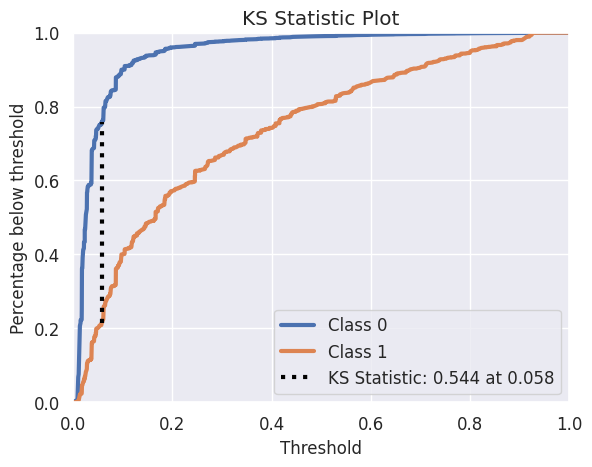

In [53]:
plot_ks_statistic(train['SeriousDlqin2yrs'],lr.predict_proba(train[vars_woe]))

In [54]:
roc_auc_score(test['SeriousDlqin2yrs'],lr.predict_proba(test[vars_woe])[:,1])

0.8581537456602677

<Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

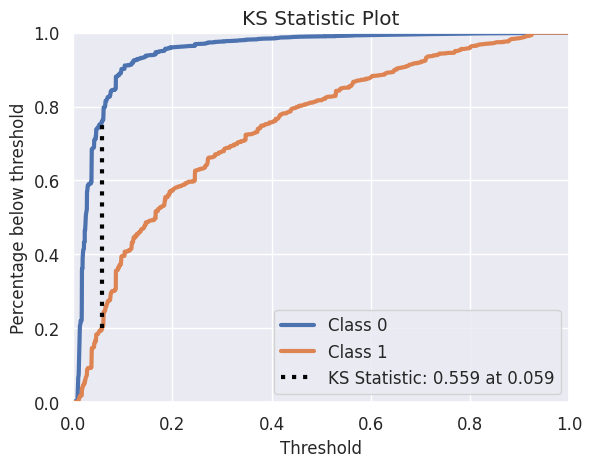

In [55]:
plot_ks_statistic(test['SeriousDlqin2yrs'],lr.predict_proba(test[vars_woe]))

## Modelos adicionales

In [58]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

### Redes neuronales

In [59]:
mlp=MLPClassifier()
grid_mlp={'activation':['logistic','tanh','relu','identity'],
          'hidden_layer_sizes':[(a,b,) for a in range(2,11) for b in range(2,11)]+[(a,) for a in range(2,21)],
          'learning_rate':['constant','invscaling','adaptive']}
grid_mlp=RandomizedSearchCV(mlp,grid_mlp,scoring='roc_auc',n_jobs=-1,n_iter=60)
grid_mlp.fit(train[vars_woe],train['SeriousDlqin2yrs'])
best_mlp=grid_mlp.best_estimator_
best_mlp

MLPClassifier(activation='tanh', hidden_layer_sizes=(14,),
              learning_rate='adaptive')

In [60]:
roc_auc_score(train['SeriousDlqin2yrs'],best_mlp.predict_proba(train[vars_woe])[:,1]),roc_auc_score(test['SeriousDlqin2yrs'],best_mlp.predict_proba(test[vars_woe])[:,1])

(0.8523530239201147, 0.8600353255609984)

<Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

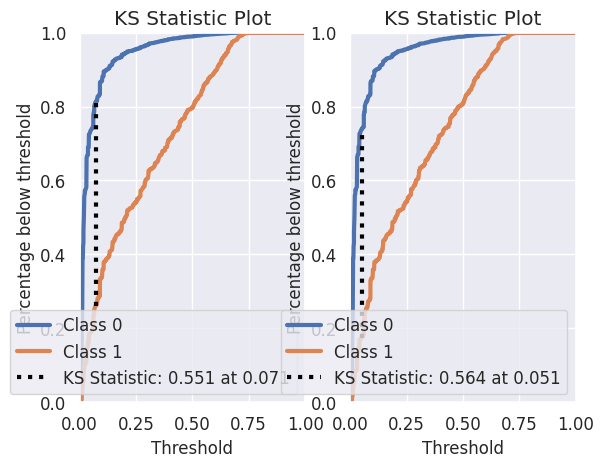

In [61]:
fig,ax=plt.subplots(1,2)
plot_ks_statistic(train['SeriousDlqin2yrs'],best_mlp.predict_proba(train[vars_woe]),ax=ax[0])
plot_ks_statistic(test['SeriousDlqin2yrs'],best_mlp.predict_proba(test[vars_woe]),ax=ax[1])

### Arbol de decisión

In [62]:
tree=DecisionTreeClassifier()
grid_tree={'criterion':['gini','entropy'],'max_depth':range(2,21),
           'min_samples_split':range(2,11),'min_samples_leaf':range(1,11),
           'class_weight':['balanced',None]}
grid_tree=RandomizedSearchCV(tree,grid_tree,scoring='roc_auc',n_jobs=-1,n_iter=60)
grid_tree.fit(train[vars_woe],train['SeriousDlqin2yrs'])
best_tree=grid_tree.best_estimator_
best_tree

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=10,
                       min_samples_split=3)

In [63]:
roc_auc_score(train['SeriousDlqin2yrs'],best_tree.predict_proba(train[vars_woe])[:,1]),roc_auc_score(test['SeriousDlqin2yrs'],best_tree.predict_proba(test[vars_woe])[:,1])

(0.853133614511256, 0.8582338568541932)

<Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

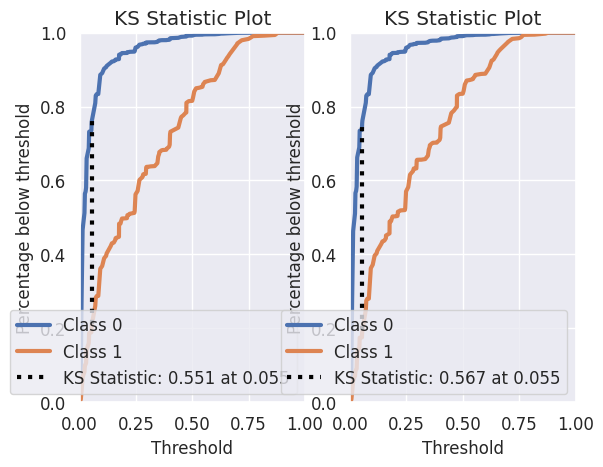

In [64]:
fig,ax=plt.subplots(1,2)
plot_ks_statistic(train['SeriousDlqin2yrs'],best_tree.predict_proba(train[vars_woe]),ax=ax[0])
plot_ks_statistic(test['SeriousDlqin2yrs'],best_tree.predict_proba(test[vars_woe]),ax=ax[1])

### Bosque Aleatorio

In [65]:
forest=RandomForestClassifier()
grid_forest={'n_estimators':[30,50,70,90],'max_depth':range(5,21),
            'min_samples_split':range(2,11),'min_samples_leaf':range(1,11),
             'max_features':['sqrt','log2'],'class_weight':['balanced',None,'balanced_subsample']}
grid_forest=RandomizedSearchCV(forest,grid_forest,scoring='roc_auc',n_jobs=-1,n_iter=60)
grid_forest.fit(train[vars_woe],train['SeriousDlqin2yrs'])
best_forest=grid_forest.best_estimator_
best_forest

RandomForestClassifier(max_depth=6, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=50)

In [66]:
roc_auc_score(train['SeriousDlqin2yrs'],best_forest.predict_proba(train[vars_woe])[:,1]),roc_auc_score(test['SeriousDlqin2yrs'],best_forest.predict_proba(test[vars_woe])[:,1])

(0.8535059530391409, 0.8594623472480067)

<Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

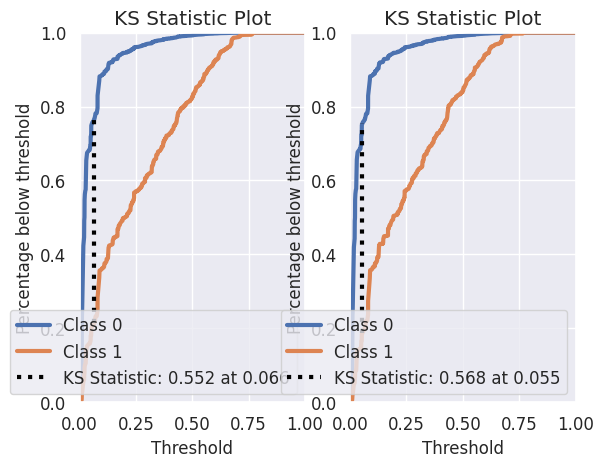

In [67]:
fig,ax=plt.subplots(1,2)
plot_ks_statistic(train['SeriousDlqin2yrs'],best_forest.predict_proba(train[vars_woe]),ax=ax[0])
plot_ks_statistic(test['SeriousDlqin2yrs'],best_forest.predict_proba(test[vars_woe]),ax=ax[1])

### SVM

In [68]:
svc=SVC()
grid_svc={'C':[.001,0.01,0.1,1],'kernel':['rbf','poly','linear','sigmoid'],
          'gamma':['auto','scale'],'probability':[True],
          'class_weight':['balanced',None],'max_iter':[100]}
grid_svc=RandomizedSearchCV(svc,grid_svc,scoring='roc_auc',n_jobs=-1,n_iter=50)
grid_svc.fit(train[vars_woe],train['SeriousDlqin2yrs'])
best_svc=grid_svc.best_estimator_
best_svc

/home/asm/amv/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/asm/amv/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/asm/amv/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/asm/amv/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/asm/amv/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).

SVC(C=0.01, kernel='linear', max_iter=100, probability=True)

In [69]:
roc_auc_score(train['SeriousDlqin2yrs'],best_svc.predict_proba(train[vars_woe])[:,1]),roc_auc_score(test['SeriousDlqin2yrs'],best_svc.predict_proba(test[vars_woe])[:,1])

(0.7732461971731753, 0.7831501292166086)

<Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

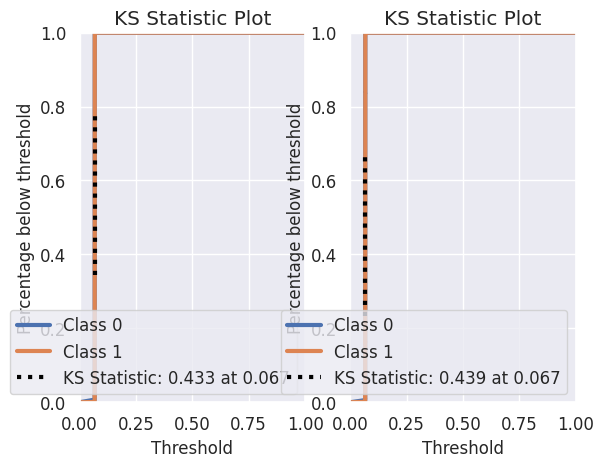

In [70]:
fig,ax=plt.subplots(1,2)
plot_ks_statistic(train['SeriousDlqin2yrs'],best_svc.predict_proba(train[vars_woe]),ax=ax[0])
plot_ks_statistic(test['SeriousDlqin2yrs'],best_svc.predict_proba(test[vars_woe]),ax=ax[1])

### KNN

In [71]:
knn=KNeighborsClassifier()
grid_knn={'n_neighbors':range(2,16),'p':[1,2],'weights':['uniform','distance'],
          'algorithm':['auto','ball_tree','kd_tree'],'leaf_size':[10,20,30,40,50],'n_jobs':[-1]}
grid_knn=RandomizedSearchCV(knn,grid_knn,scoring='roc_auc',n_jobs=-1,n_iter=50)
grid_knn.fit(train[vars_woe],train['SeriousDlqin2yrs'])
best_knn=grid_knn.best_estimator_
best_knn

KNeighborsClassifier(leaf_size=10, n_jobs=-1, n_neighbors=14)

In [72]:
roc_auc_score(train['SeriousDlqin2yrs'],best_knn.predict_proba(train[vars_woe])[:,1]),roc_auc_score(test['SeriousDlqin2yrs'],best_knn.predict_proba(test[vars_woe])[:,1])

(0.8045472067763779, 0.8032543575296003)

<Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

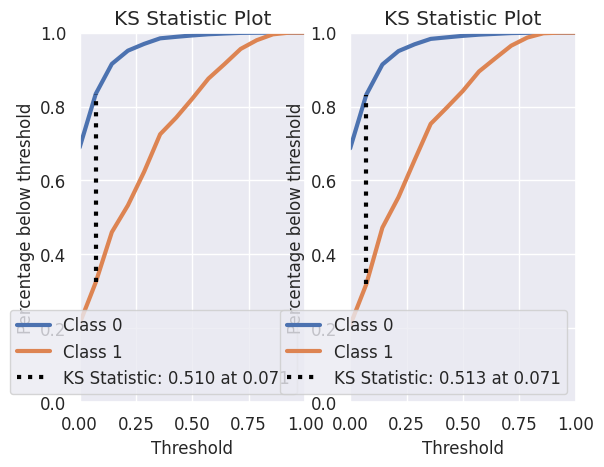

In [73]:
fig,ax=plt.subplots(1,2)
plot_ks_statistic(train['SeriousDlqin2yrs'],best_knn.predict_proba(train[vars_woe]),ax=ax[0])
plot_ks_statistic(test['SeriousDlqin2yrs'],best_knn.predict_proba(test[vars_woe]),ax=ax[1])

### VotingClassifier

In [74]:
vc=VotingClassifier(estimators=[('logistic',modelo),('mlp',best_mlp),('forest',best_forest)],n_jobs=-1,voting='soft')
vc.fit(train[vars_woe],train['SeriousDlqin2yrs'])

VotingClassifier(estimators=[('logistic',
                              LogisticRegression(C=0.7000000000000001,
                                                 class_weight='balanced')),
                             ('mlp',
                              MLPClassifier(activation='tanh',
                                            hidden_layer_sizes=(14,),
                                            learning_rate='adaptive')),
                             ('forest',
                              RandomForestClassifier(max_depth=6,
                                                     min_samples_leaf=4,
                                                     min_samples_split=5,
                                                     n_estimators=50))],
                 n_jobs=-1, voting='soft')

In [75]:
roc_auc_score(train['SeriousDlqin2yrs'],vc.predict_proba(train[vars_woe])[:,1]),roc_auc_score(test['SeriousDlqin2yrs'],vc.predict_proba(test[vars_woe])[:,1])

(0.8522018105651326, 0.8603390062836185)

<Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

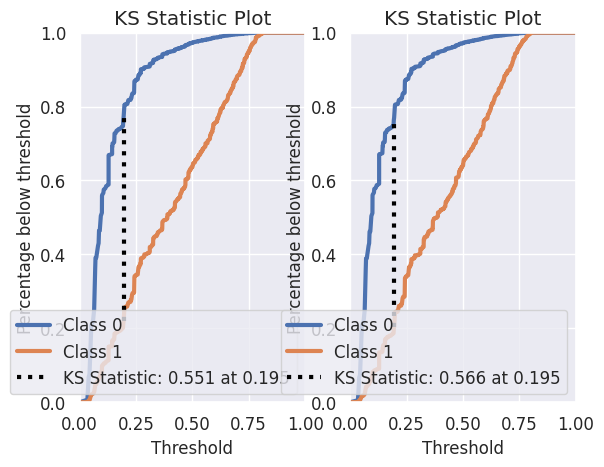

In [76]:
fig,ax=plt.subplots(1,2)
plot_ks_statistic(train['SeriousDlqin2yrs'],vc.predict_proba(train[vars_woe]),ax=ax[0])
plot_ks_statistic(test['SeriousDlqin2yrs'],vc.predict_proba(test[vars_woe]),ax=ax[1])

In [77]:
#pred['Probability']=modelo.predict_proba(pred[vars_woe])[:,1]
#pred[['Id','Probability']].to_csv(ruta+'/pred.csv',index=False)